In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm

THEANO_FLAGS = 'exception_verbosity=high'

# Test 1: Scalar ODE with 1 parameter

$$ y' = exp(-t) - \alpha y \quad y(0) = 0 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 1
n_odeparams = 1

#Times to evaluate the solution
times = np.arange(0.25,8,0.25)

#Instantiate the ODEModel
ode_model = ODEModel(func = test_ode_func_1, 
                   t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_odeparams = n_odeparams)

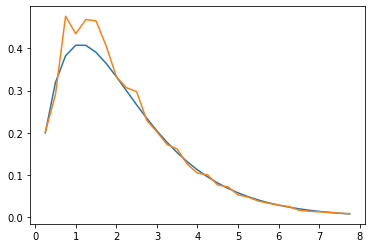

In [3]:
#Simulate the data and create data to learn from
sims, sens = ode_model.simulate([0.8,0])


Y = scipy.stats.lognorm.rvs(s = 0.1, scale = sims)


plt.plot(times, sims)
plt.plot(times,Y)




In [4]:
class solveCached(object):
    def __init__(self, times, n_params, n_outputs):
      
        self._times = times
        self._n_params = n_params
        self._n_outputs = n_outputs
        self._cachedParam = np.zeros(n_params)
        self._cachedSens = np.zeros((len(times), n_outputs, n_params))
        self._cachedState = np.zeros((len(times),n_outputs))
        
    def __call__(self, x):
        
        if np.all(x==self._cachedParam):
            state, sens = self._cachedState, self._cachedSens
            
        else:
            state, sens = ode_model.simulate(x)
        
        return state,sens
    

cached_solver=solveCached(times, 1 + 1, 1)

In [5]:
def state(x):
    State, Sens = cached_solver(np.array(x,dtype=np.float64))
    cached_solver._cachedState, cached_solver._cachedSens, cached_solver._cachedParam = State, Sens, x
    return State.ravel()

def numpy_vsp(x, g):    
    numpy_sens = cached_solver(np.array(x,dtype=np.float64))[1].reshape((n_states*len(times),len(x)))
    return numpy_sens.T.dot(g)

class ODEGradop(theano.Op):
    def __init__(self, numpy_vsp):
        self._numpy_vsp = numpy_vsp

    def make_node(self, x, g):
        x = theano.tensor.as_tensor_variable(x)
        g = theano.tensor.as_tensor_variable(g)
        node = theano.Apply(self, [x, g], [g.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]

        g = inputs_storage[1]
        out = output_storage[0]
        out[0] = self._numpy_vsp(x, g)       # get the numerical VSP

class ODEop(theano.Op):

    def __init__(self, state, numpy_vsp):
        self._state = state
        self._numpy_vsp = numpy_vsp

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)

        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]
        
        out[0] = self._state(x)               # get the numerical solution of ODE states

    def grad(self, inputs, output_grads):
        x = inputs[0]
        g = output_grads[0]

        grad_op = ODEGradop(self._numpy_vsp)  # pass the VSP when asked for gradient 
        grad_op_apply = grad_op(x, g)
        
        return [grad_op_apply]
    
my_ODEop = ODEop(state,numpy_vsp)


In [15]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    alpha = pm.HalfNormal('alpha',1)
    y0 = pm.HalfNormal('y0',1)
    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    all_params = pm.math.stack([alpha, y0],axis=0)
    pprint = tt.printing.Print('all_params')(all_params)
    
    ode_sol = my_ODEop(all_params)
    oprint = tt.printing.Print('ode_sol')(ode_sol)
    
    forward = ode_sol.reshape(Y.shape)
    fprint = tt.printing.Print('forward')(pm.math.log(forward))
    
    ode = pm.Deterministic('ode',ode_sol)
    
    

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
#     Y_obs = pm.Normal('Y_obs', mu=forward, sd=sigma, observed=Y)
#     Y_obs = pm.Lognormal('Y_obs', mu=forward, sd=sigma, observed=Y)
    
    trace = pm.sample(1000, tune=500, chains = 4, init='adapt_diag', target_accept = 0.99)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


all_params __str__ = [0.79788456 0.79788456]
ode_sol __str__ = [0.8533013  0.8545225  0.82111999 0.76696489 0.70173658 0.63205315
 0.56231488 0.49533123 0.43278432 0.37556982 0.32404585 0.27821324
 0.23784487 0.20257725 0.17197447 0.14557184 0.12290488 0.10352785
 0.08702477 0.07301532 0.0611571  0.05114563 0.0427128  0.03562439
 0.02967723 0.02469603 0.02053034 0.01705154 0.01415011 0.01173308
 0.00972177]
forward __str__ = [[-0.15864257]
 [-0.15721245]
 [-0.19708603]
 [-0.26531426]
 [-0.35419719]
 [-0.4587818 ]
 [-0.5756933 ]
 [-0.70252859]
 [-0.83751578]
 [-0.97931088]
 [-1.12687025]
 [-1.2793674 ]
 [-1.43613664]
 [-1.596634  ]
 [-1.76040924]
 [-1.92708558]
 [-2.09634455]
 [-2.26791463]
 [-2.44156244]
 [-2.61708598]
 [-2.79430928]
 [-2.97307815]
 [-3.15325673]
 [-3.33472473]
 [-3.51737528]
 [-3.70111286]
 [-3.88585173]
 [-4.07151495]
 [-4.258033  ]
 [-4.44534296]
 [-4.6333877 ]]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, y0, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:32<00:00,  8.02draws/s]


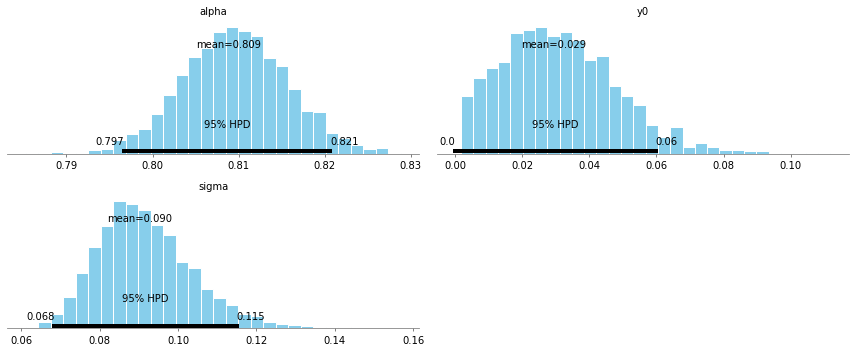

In [22]:
pm.posteriorplot.plot_posterior(trace,varnames = ['alpha','y0','sigma']);

In [23]:
print(pm.gelman_rubin(trace))

print(pm.effective_n(trace))

{'alpha': 1.0011816901407606, 'y0': 1.0003748723686305, 'sigma': 0.9995728343436576, 'ode': array([[1.00040161],
       [1.00047515],
       [1.00060142],
       [1.00078764],
       [1.00103667],
       [1.00133872],
       [1.00166486],
       [1.00197054],
       [1.00221233],
       [1.00236689],
       [1.00243649],
       [1.00243994],
       [1.00240017],
       [1.00233648],
       [1.00226235],
       [1.00218611],
       [1.0021124 ],
       [1.00204351],
       [1.00198037],
       [1.00192313],
       [1.00187156],
       [1.00182521],
       [1.0017836 ],
       [1.00174622],
       [1.0017126 ],
       [1.00168231],
       [1.00165497],
       [1.00163022],
       [1.00160778],
       [1.00158738],
       [1.0015688 ]])}
{'alpha': 1665.5787324882538, 'y0': 1556.9851592226137, 'sigma': 2428.71749500396, 'ode': array([[1558.86611541],
       [1563.18321433],
       [1572.95585329],
       [1592.52157389],
       [1677.96269034],
       [1886.02901339],
       [2255.622365  

In [13]:
with first_model:
    ppc = pm.sample_ppc(trace)

100%|██████████| 1000/1000 [00:18<00:00, 53.95it/s]


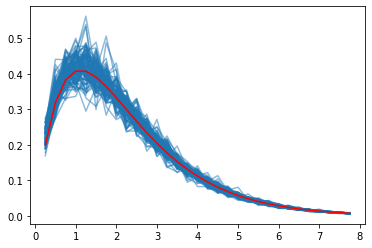

In [14]:
yobs = ppc['Y_obs']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.5)
    
plt.plot(times,sims, color = 'red')

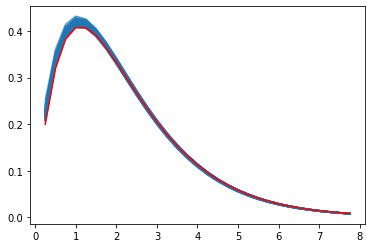

In [20]:
yobs = trace['ode']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.5)
    
plt.plot(times,sims, color = 'red')

In [21]:
?pm.posteriorplot.plot_posterior